# Project Simulation & Optimization
Given is a rod with cross-section $A$, thermal conductivity $\lambda$ with a constant heat supply $Q_0$ along the rod.

In [16]:
import numpy as np
import matplotlib.pyplot as plt

The temperature profile is described by the differential equation:  
$T'' + \dfrac{Q_0}{\lambda\,A}=0$  
Integrating and using the boundary conditions $T(0)=0$ and $T(l)=0$ yields:  
$T = -\dfrac{Q_0}{2\,\lambda\,A}\,x^2 + \dfrac{Q_0}{2\,\lambda\,A}\,x$

In [17]:
Q0 = 15e-6 # J/m^2s
lamb = 5 # J/°Cms
Across = 1e-6 # m^2
l = 1 # m

### analytical Function of $T$

Text(0, 0.5, 'temperature on beam in °C')

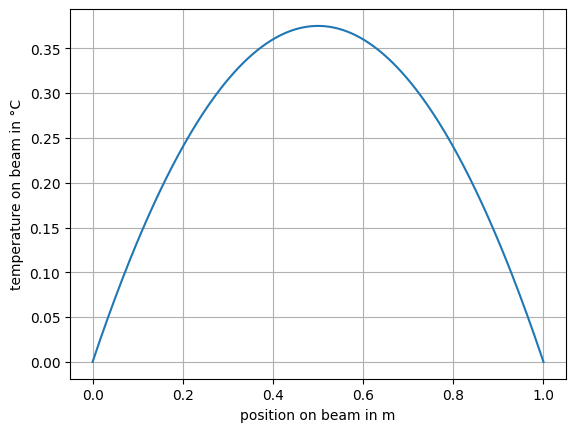

In [18]:
def T(x):
    return -Q0/(2*lamb*Across)*x**2 + Q0/(2*lamb*Across)*x

def T_dd(x):
    return np.ones_like(x)*-Q0/(2*lamb*Across)

x = np.linspace(0, 1, 300)
T_analytic = T(x)
plt.plot(x, T_analytic)
plt.grid()
plt.xlabel("position on beam in m")
plt.ylabel("temperature on beam in °C")

### generate system of equations

In [19]:
n = np.size(x)
h = x[1] - x[0]

A = (-2*np.eye(n) +
     np.eye(n, k=1) +
     np.eye(n, k=-1))
A = A / h**2

b = np.full(n, -Q0 / (lamb * Across))

A[0, :] = 0
A[0, 0] = 1
b[0] = 0

A[-1, :] = 0
A[-1, -1] = 1
b[-1] = 0

print(A)

[[ 1.00000e+00  0.00000e+00  0.00000e+00 ...  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 8.94010e+04 -1.78802e+05  8.94010e+04 ...  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 0.00000e+00  8.94010e+04 -1.78802e+05 ...  0.00000e+00  0.00000e+00
   0.00000e+00]
 ...
 [ 0.00000e+00  0.00000e+00  0.00000e+00 ... -1.78802e+05  8.94010e+04
   0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00 ...  8.94010e+04 -1.78802e+05
   8.94010e+04]
 [ 0.00000e+00  0.00000e+00  0.00000e+00 ...  0.00000e+00  0.00000e+00
   1.00000e+00]]


### Solver implementations

In [20]:
import time
# der wahnsinns zeitstopperdecorator
def timedit(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Function '{func.__name__}' executed in: {execution_time:.4f} seconds")
        return result
    return wrapper

def backward_sub(A,b):
    n = len(b)
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        s = 0.0
        for j in range(i + 1, n):
            s += A[i, j] * x[j]
        x[i] = (b[i].item() - s) / A[i, i]
    return x

def forward_sub(A,b):
    n = len(b)
    y = np.zeros(n)
    for i in range(n):
        c = 0.0
        for j in range(i):
            c += A[i, j] * y[j]
        y[i] = b[i] - c
    return y



@timedit
def solve_numpy(A,b):
    return np.linalg.solve(A,b)

@timedit
def solve_gauss(A,b):
    n = len(b)

    # factorization
    for i in range(n - 1):
        for j in range(i + 1, n):
            lji = A[j, i] / A[i, i]

            for k in range(i, n):
                A[j, k] -= lji * A[i, k]

            b[j] -lji * b[i]

    # back subs.
    x = backward_sub(A,b)
    return x



### Solve system

In [21]:
T_numpy = solve_numpy(A,b)
T_gauss = solve_gauss(A,b)

Function 'solve_numpy' executed in: 0.0000 seconds
Function 'solve_gauss' executed in: 2.4841 seconds


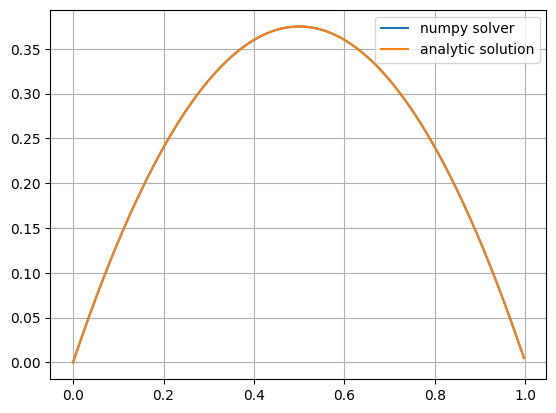

In [22]:
end = -1
plt.plot(x[0:end],T_numpy[0:end], label="numpy solver")
plt.plot(x[0:end],T_analytic[0:end], label="analytic solution")
plt.legend()
plt.grid()

### finite difference approximation of $T''$

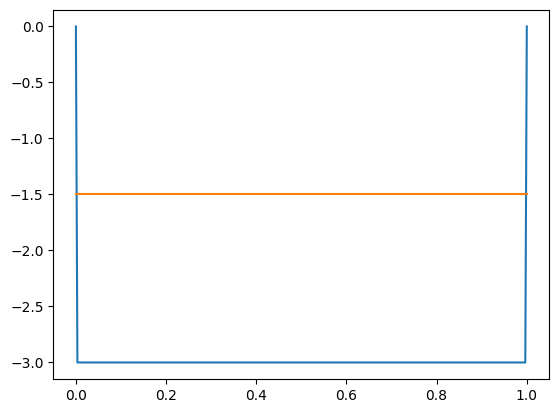

In [23]:
T_dd_app = np.zeros_like(x, dtype=float)
T_dd_app[1:-1] = (T(x[1:-1]+h) - 2*T(x[1:-1]) + T(x[1:-1]-h)) / h**2

plt.plot(x,T_dd_app)
plt.plot(x, T_dd(x))
